In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pdb

from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from ntwk import LIFNtwk


# INPUT PARAMS (order = [G, G_I, PC, INH])
## G excitation
R_G = 1000  # rate
W_PC_G = 0.0002  # weight

## G inhibition
R_G_I =  1000  # rate
W_PC_G_I = 0  # weight

## PC excitation
N_SPKS_PC = 30  # num pc spks
W_PC_PC = .002  # weight
T_PC = (.11, .115)  # time window of PC inputs

## INH (recurrent) inhibition
N_SPKS_INH = 10  # num inh spks
W_PC_INH = .1  # weight
T_INH = (.115, .118)  # time window of INH inputs


# MEMBRANE PARAMS
T_M_PC = 0.05
E_L_PC = -0.068
V_TH_PC = -0.036
T_R_PC = 0.008


# SYNAPTIC PARAMS
E_E = 0
E_I = -0.08
T_E = 0.02
T_I = 0.001


# SMLN PARAMS
DT = 0.0005
T = 0.23
N_TRIALS = 100

In [9]:
# make ntwk
ntwk = LIFNtwk(
    t_m=np.repeat(T_M_PC, 3),
    e_l=np.repeat(E_L_PC, 3),
    v_th=np.repeat(V_TH_PC, 3),
    v_r=np.repeat(E_L_PC, 3),
    t_r=np.repeat(T_R_PC, 3),
    es_syn={'E': E_E, 'I': E_I},
    ts_syn={'E': T_E, 'I': T_I},
    ws_up={
        'E': np.array([
            [2*W_PC_G, 2*W_PC_G, W_PC_G],  # G inputs (1,2 are LTP-IE-tagged, 3 is not)
            [0, 0, 0],  # for INH
            [W_PC_PC, 0, W_PC_PC],  # PC inputs (1 gets PC input, 2 doesn't, 3 does)
            [0, 0, 0],  # for INH
        ]).T,
        'I': np.array([
            [0, 0, 0],  # for E
            [W_PC_G_I, W_PC_G_I, W_PC_G_I],  # G_I
            [0, 0, 0],  # for E
            [W_PC_INH, W_PC_INH, W_PC_INH],  # INH
        ]).T,
    },
    ws_rcr={'E': np.zeros((3, 3)), 'I': np.zeros((3, 3))},
)

In [10]:
# create spks_up instances
t = np.arange(0, T, DT)
spks_ups = []

# make inputs
for _ in range(N_TRIALS):
    spks_up = np.zeros((len(t), 4))

    # add G inputs
    spks_up[:, 0] = np.random.poisson(R_G*DT, len(t))
    
    # add G_I inputs
    spks_up[:, 1] = np.random.poisson(R_G_I*DT, len(t))

    # add PC inputs
    t_idxs_pc = np.round(np.linspace(*T_PC, N_SPKS_PC)/DT).astype(int)
    spks_up[t_idxs_pc, 2] = 1

    # add INH inputs
    t_idxs_inh = np.round(np.linspace(*T_INH, N_SPKS_INH)/DT).astype(int)
    spks_up[t_idxs_inh, 3] = 1
    
    spks_ups.append(spks_up.copy())

In [11]:
# run ntwk
rsps = []
for spks_up in spks_ups:
    rsp = ntwk.run(spks_up=spks_up, dt=DT, vs_0=np.repeat(E_L_PC, 3))
    rsps.append(rsp)
    
xmpl = 0

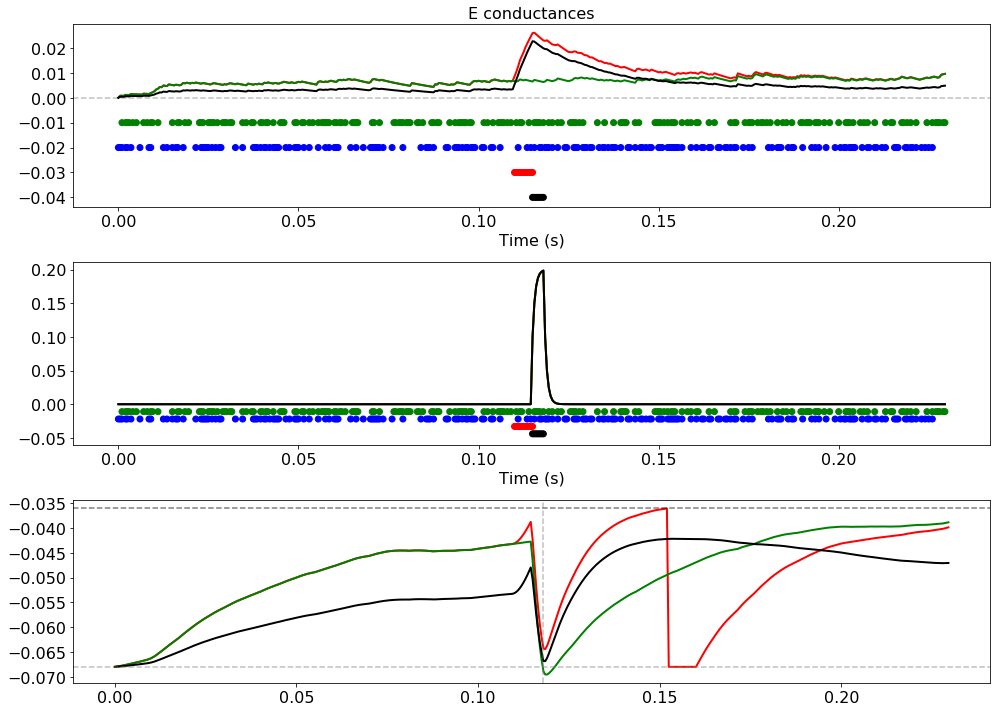

In [18]:
# example plots
fig, axs = plt.subplots(3, 1, figsize=(14, 10), tight_layout=True)

# example conductances
axs[0].axhline(0, color='gray', alpha=0.5, ls='--')

# E conductances
axs[0].plot(t, rsps[xmpl].gs['E'][:, 0], color='r', lw=2)  # cell 1 (LTP-IE-tagged, PC input)
axs[0].plot(t, rsps[xmpl].gs['E'][:, 1], color='g', lw=2)  # cell 2 (LTP-IE-tagged, no PC input)
axs[0].plot(t, rsps[xmpl].gs['E'][:, 2], color='k', lw=2)  # cell 3 (not LTP-IE-tagged but with PC input)

# example inputs
y_offsets = -np.arange(1, 5) * .01
t_idxs_up, nrn_idxs_up = spks_ups[0].nonzero()
ts_up = t_idxs_up*DT
nrn_ys_up = y_offsets[nrn_idxs_up]

axs[0].scatter(ts_up, nrn_ys_up, c=np.array(['g', 'b', 'r', 'k'])[nrn_idxs_up])
#axs[0].set_yticks(y_offsets)
#axs[0].set_yticklabels(['G', 'G_I', 'PC', 'INH'])
axs[0].set_xlabel('Time (s)')
axs[0].set_title('E conductances')

# I conductances
axs[1].plot(t, rsps[xmpl].gs['I'][:, 0], color='r', lw=2)  # cell 1 (RED: LTP-IE-tagged, PC input)
axs[1].plot(t, rsps[xmpl].gs['I'][:, 1], color='g', lw=2)  # cell 2 (GREEN: LTP-IE-tagged, no PC input)
axs[1].plot(t, rsps[xmpl].gs['I'][:, 2], color='k', lw=2)  # cell 3 (BLUE: not LTP-IE-tagged but with PC input)

# example inputs
y_offsets = -np.arange(1, 5) * .011
t_idxs_up, nrn_idxs_up = spks_ups[0].nonzero()
ts_up = t_idxs_up*DT
nrn_ys_up = y_offsets[nrn_idxs_up]

axs[1].scatter(ts_up, nrn_ys_up, c=np.array(['g', 'b', 'r', 'k'])[nrn_idxs_up])
#axs[1].set_yticks(y_offsets)
#axs[1].set_yticklabels(['G', 'G_I', 'PC', 'INH'])
axs[1].set_xlabel('Time (s)')

# membrane voltage
axs[2].plot(t, rsps[xmpl].vs[:, 0], color='r', lw=2)  # cell 1 (RED: LTP-IE-tagged, PC input)
axs[2].plot(t, rsps[xmpl].vs[:, 1], color='g', lw=2)  # cell 2 (GREEN: LTP-IE-tagged, no PC input)
axs[2].plot(t, rsps[xmpl].vs[:, 2], color='k', lw=2)  # cell 3 (BLUE: not LTP-IE-tagged but with PC input)

axs[2].axhline(E_L_PC, color='gray', alpha=0.5, ls='--')
axs[2].axhline(V_TH_PC, color='k', alpha=0.5, ls='--')
axs[2].axvline(T_INH[1], color='gray', alpha=0.5, ls='--')

for ax in list(axs):
    set_font_size(ax, 16)


# mean plots

In [17]:
xmpl = 3